# 数据预处理

## 数据读取

In [2]:
def read_data(path):
    # 读取train.txt格式的数据，返回字典
    data = {}
    with open(path, 'r') as f:
        while True:
            line = f.readline().strip()
            if not line:  # EOF
                break
            # 读取user_id和rate_num
            user_id, rate_num = line.split('|')
            rate_num = int(rate_num)
            user_id = int(user_id)
            # 读取用户的评分数据
            rate_data = {}
            for i in range(rate_num):
                item_id, score = f.readline().strip().split()
                item_id = int(item_id)
                score = int(score)
                rate_data[item_id] = score
            # 保存该用户的数据
            data[user_id] = rate_data
    return data

In [3]:
PATH = 'data/train.txt'
data = read_data(PATH)

## 数据分析

### 统计用户和商品的id情况

In [3]:
user_set = set()  # 所有用户的集合
item_set = set()  # 所有物品的集合
rating_count = 0  # 记录所有用户评分的次数
score_map = {}  # 每个评分的次数统计

for user_id, rate_data in data.items():  # 遍历所有用户
    user_set.add(user_id)
    for item_id, score in rate_data.items():  # 遍历用户的评分
        item_set.add(item_id)
        rating_count += 1
        if score in score_map:
            score_map[score] += 1
        else:
            score_map[score] = 1

print('用户数：', len(user_set))
print('物品数：', len(item_set))
print('累积评分次数：', rating_count)

用户数： 19835
物品数： 455691
累积评分次数： 5001507


### 统计数据分布情况

In [4]:
max_user_id = max(user_set)
max_item_id = max(item_set)
min_user_id = min(user_set)
min_item_id = min(item_set)
print('最大用户id：', max_user_id)
print('最小用户id：', min_user_id)
print('最大物品id：', max_item_id)
print('最小物品id：', min_item_id)
print('用户id是否连续：', len(user_set) == int(max_user_id) - int(min_user_id) + 1)
print('物品id是否连续：', len(item_set) == int(max_item_id) - int(min_item_id) + 1)

最大用户id： 19834
最小用户id： 0
最大物品id： 624960
最小物品id： 0
用户id是否连续： True
物品id是否连续： False


In [5]:
# 统计次数最多的评分
max_score = max(score_map.items(), key=lambda x: x[1])
min_score = min(score_map.items(), key=lambda x: x[1])
print('最多的评分：', max_score)
print('最少的评分：', min_score)
print('评分种类：', len(score_map))
average_score = rating_count / len(score_map)
print('每个评分的平均次数：', average_score)

最多的评分： (0, 1535563)
最少的评分： (7, 247)
评分种类： 101
每个评分的平均次数： 49519.87128712871


In [6]:
# 绘制得分-次数 散点图
import matplotlib.pyplot as plt

def draw_scatter(x, y, xlabel, ylabel, title):
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

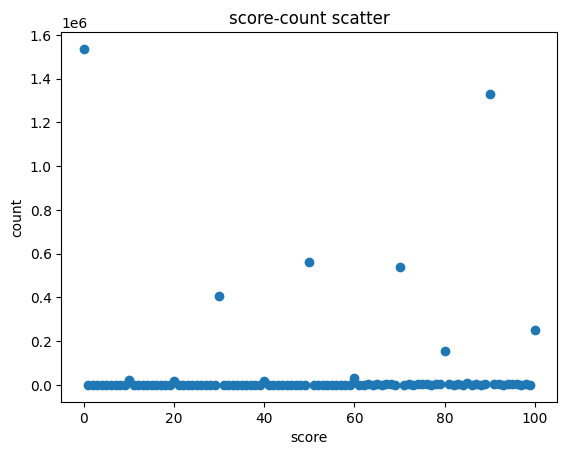

In [7]:
x = list(score_map.keys())
y = list(score_map.values())
draw_scatter(x, y, 'score', 'count', 'score-count scatter')

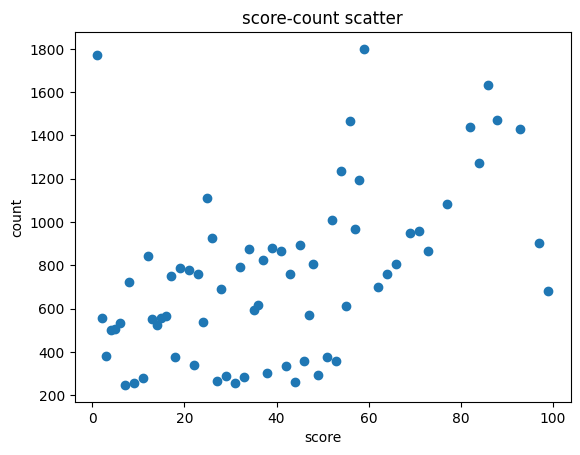

In [8]:
# 剔除掉次数超过2000的评分
clean_score_map = {k: v for k, v in score_map.items() if v < 2000}
x = list(clean_score_map.keys())
y = list(clean_score_map.values())
draw_scatter(x, y, 'score', 'count', 'score-count scatter')

### 统计均值与偏差

In [14]:
# 全局平均评分
total_score = 0
for score, count in score_map.items():
    total_score += score * count
average_score = total_score / rating_count
print('全局平均评分：', average_score)

全局平均评分： 49.50627100991761


In [15]:
def cal_user_bias(data, average_score):
    # 统计每个用户的平均打分
    user_average_score = {}
    for user_id, rate_data in data.items():
        total_score = 0
        for score in rate_data.values():
            total_score += score
        user_average_score[user_id] = total_score / len(rate_data)
    # 每个用户与全局平均评分的偏差
    user_bias = {}
    for user_id, u_ave_score in user_average_score.items():
        user_bias[user_id] = u_ave_score - average_score
    # 最小偏差，最大偏差，平均偏差
    max_bias = max(user_bias.items(), key=lambda x: x[1])
    min_bias = min(user_bias.items(), key=lambda x: x[1])
    total_bias = 0
    for bias in user_bias.values():
        total_bias += bias
    average_bias = total_bias / len(user_bias)
    return user_average_score, user_bias, max_bias, min_bias, average_bias

In [16]:
user_average_score, user_bias, max_bias, min_bias, average_bias = cal_user_bias(data, average_score)
print('最大偏差：', max_bias)
print('最小偏差：', min_bias)
print('平均偏差：', average_bias)

最大偏差： (547, 50.49372899008239)
最小偏差： (413, -49.50627100991761)
平均偏差： 20.32124186733326


In [18]:
def cal_item_bias(data, average_score):
    # 统计物品得分
    item_scores = {}
    for user_id, rate_data in data.items():
        for item_id, score in rate_data.items():
            if item_id in item_scores:
                item_scores[item_id].append(score)
            else:
                item_scores[item_id] = [score]
    # 计算物品平均得分
    item_average_score = {}
    for item_id, scores in item_scores.items():
        item_average_score[item_id] = sum(scores) / len(scores)
    # 计算物品偏差
    item_bias = {}
    for item_id, i_ave_score in item_average_score.items():
        item_bias[item_id] = i_ave_score - average_score
    # 最大偏差，最小偏差，平均偏差
    max_bias = max(item_bias.items(), key=lambda x: x[1])
    min_bias = min(item_bias.items(), key=lambda x: x[1])
    total_bias = 0
    for bias in item_bias.values():
        total_bias += bias
    average_bias = total_bias / len(item_bias)
    return item_average_score, item_bias, max_bias, min_bias, average_bias

In [19]:
item_average_score, item_bias, max_bias, min_bias, average_bias = cal_item_bias(data, average_score)
print('最大偏差：', max_bias)
print('最小偏差：', min_bias)
print('平均偏差：', average_bias)

最大偏差： (342087, 50.49372899008239)
最小偏差： (536256, -49.50627100991761)
平均偏差： -5.746944408888505


## 训练集和验证集划分

In [12]:
import random

random.seed(0)
def split_data(data, ratio=0.8, shuffle=True):
    # 将数据集划分为训练集和测试集
    train_data = {}
    validate_data = {}
    # 截取数据
    for user in data.keys():
        item= list(data[user].keys())
        train_data[user] = {}
        validate_data[user] = {}
        if shuffle:
            random.shuffle(item)
        for i in range(int(len(item) * ratio)):
            user_id, item_id = user, item[i]
            train_data[user_id][item_id] = data[user_id][item_id]
        for i in range(int(len(item) * ratio), len(item)):
            user_id, item_id = user, item[i]
            validate_data[user_id][item_id] = data[user_id][item_id]
    return train_data, validate_data

In [15]:
train_data, validate_data = split_data(data)
print('train_data:', len(train_data))
print('validate_data:', len(validate_data))
print(len(train_data) == len(validate_data) == len(data))
print(len(train_data) / len(data))

train_data: 19835
validate_data: 19835
True
1.0


In [16]:
def write_data(data, path):
    # 将数据写入文件
    with open(path, 'w') as f:
        for user_id, rate_data in data.items():
            f.write(f'{user_id}|{len(rate_data)}\n')
            for item_id, score in rate_data.items():
                f.write(f'{item_id} {score}\n')

In [17]:
PATH_train = 'data/train_data.txt'
PATH_validate = 'data/validate_data.txt'
write_data(train_data, PATH_train)
write_data(validate_data, PATH_validate)